<a href="https://colab.research.google.com/github/XimenaRamirezA/AI-FIME-2024/blob/main/Proyecto_Final_PDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mejora y Segmentación de Imágenes Médicas para Diagnóstico Asistido por Computadora**
Proyecto FINAL

*Procesamiento Digital de Imágenes*
Equipo:
* Ximena Ramirez
* Ingrid Martínez
* Gonzalo Hernández
* Alejandro Aguilar
*Diego Tovias

**Objetivo:**
Desarrollar un algoritmo que procese imágenes médicas (por ejemplo, radiografías, imágenes de resonancia magnética o tomografías) para resaltar estructuras anatómicas o patológicas, como huesos, tejidos blandos o posibles tumores, usando técnicas clásicas de procesamiento digital.



In [83]:
# Importación de Librerías
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import ipywidgets as widgets
from IPython.display import display

*Cargamos la imagen*

In [84]:
# Cargar imagen médica en escala de grises
img = cv2.imread("/content/Viral/Viral Pneumonia-1.png", cv2.IMREAD_GRAYSCALE)


**Análisis y ecualización de histogramas**

En esta sección se analiza el histograma de una imagen médica en escala de grises. Primero, se visualiza el histograma original para observar la distribución de los niveles de intensidad. Luego, se aplica la ecualización de histograma con el objetivo de mejorar el contraste de la imagen, permitiendo resaltar detalles que pueden no ser visibles en la imagen original. Se muestra la imagen resultante y su histograma para comparar visualmente los efectos de la ecualización.



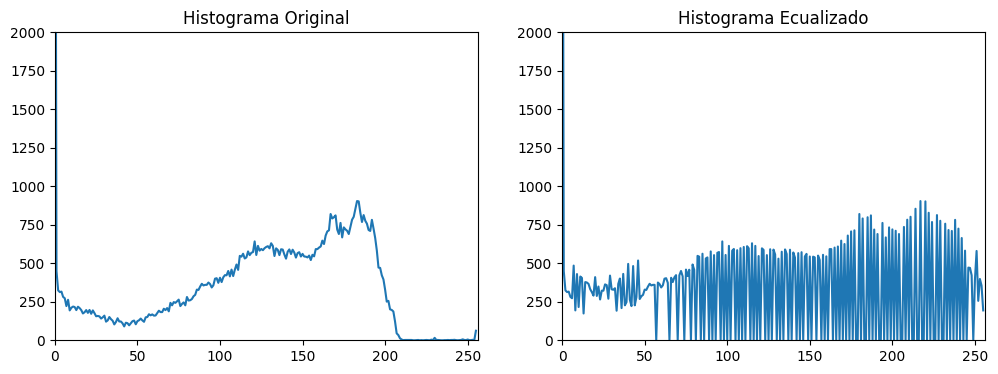

Imagen original


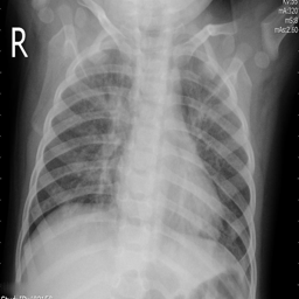

Imagen ecualizada


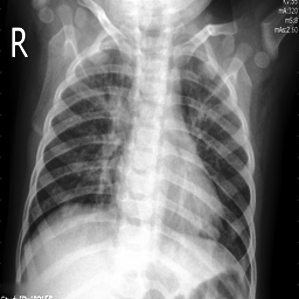

In [85]:
# 1. HISTOGRAMA ORIGINAL Y ECUALIZADO
hist_original = cv2.calcHist([img], [0], None, [256], [0, 256])
img_eq = cv2.equalizeHist(img)
hist_eq = cv2.calcHist([img_eq], [0], None, [256], [0, 256])

# Mostrar histogramas
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Histograma Original")
plt.plot(hist_original), plt.xlim([0, 256])
plt.ylim([0, 2000])
plt.subplot(1, 2, 2)
plt.title("Histograma Ecualizado")
plt.plot(hist_eq), plt.xlim([0, 256])
plt.ylim([0, 2000])
plt.show()

#imagen normal
print("Imagen original")
cv2_imshow(img)
#imagen equalizada
print("Imagen ecualizada")
cv2_imshow(img_eq)

**Operaciones aritméticas y lógicas**

Se realiza una operación de resta entre la imagen original y una versión suavizada (filtrada con desenfoque gaussiano). Esta técnica permite resaltar bordes y detalles finos, ya que al eliminar las regiones suavizadas se conservan únicamente las zonas con alta variación de intensidad.



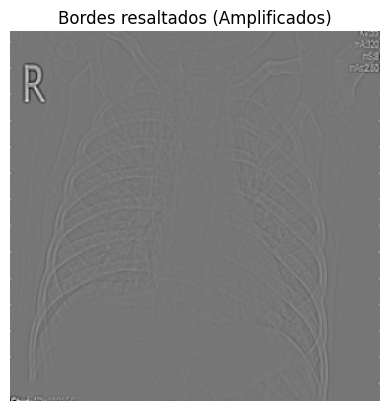

In [86]:
# Convertir imagen a float para permitir valores negativos
img_f32 = np.float32(img)

# Aplicar desenfoque gaussiano
img_blur = cv2.GaussianBlur(img_f32, (5, 5), 0)

# Resta: bordes = original - suavizada
img_edges = img_f32 - img_blur

# Amplificar los bordes multiplicando (aumenta contraste)
img_edges *= 4  # puedes ajustar este valor si quieres aún más contraste

# Normalizar a rango 0–255 y convertir a uint8 para visualización
img_edges_norm = cv2.normalize(img_edges, None, 0, 255, cv2.NORM_MINMAX)
img_edges_uint8 = np.uint8(img_edges_norm)

# Mostrar con matplotlib
plt.figure()
plt.imshow(img_edges_uint8, cmap='gray')
plt.title("Bordes resaltados (Amplificados)")
plt.axis('off')
plt.show()



Se crean máscaras binarias que simulan zonas de interés en la imagen. A través de operaciones lógicas como AND y OR, se puede aplicar la máscara para enfocar o fusionar regiones específicas, como puede hacerse en imágenes médicas para destacar ciertos tejidos u órganos.



Zona enfocada con AND


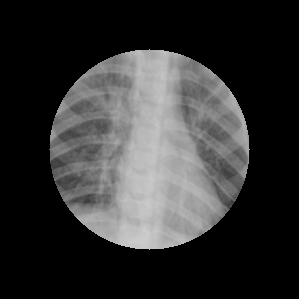

Zona enfocada con OR


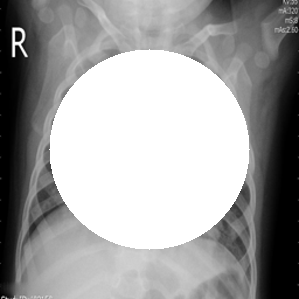

In [87]:
# 3. OPERACIONES LÓGICAS CON MÁSCARA
# Crear máscara circular
mask = np.zeros(img.shape, dtype="uint8")
cv2.circle(mask, (img.shape[1]//2, img.shape[0]//2), 100, 255, -1)
masked_and = cv2.bitwise_and(img, mask)
masked_or = cv2.bitwise_or(img, mask)

#mostrar
print("Zona enfocada con AND")
cv2_imshow(masked_and)
print("Zona enfocada con OR")
cv2_imshow(masked_or)


**Filtros usando máscaras**

Se aplican filtros paso bajo como el filtro de media y el filtro gaussiano, ambos diseñados para reducir el ruido en la imagen. Estos filtros eliminan detalles finos y transiciones abruptas, siendo útiles en el preprocesamiento de imágenes antes de aplicar técnicas de segmentación o análisis.

Así como también, aplicamos dos filtros pasoo alto, como el Laplaciano y el Sobel. Los cuales se utilizan para detectar bordes y transiciones intensas en la imagen. Estos bordes suelen representar contornos de estructuras anatómicas importantes en imágenes médicas.



Filtro media


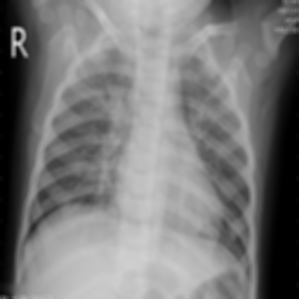

Filtro Gaussiano


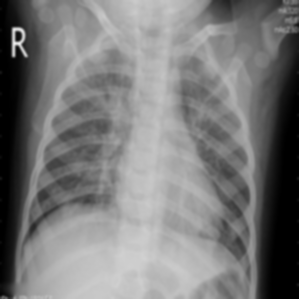

Filtro Laplaciano


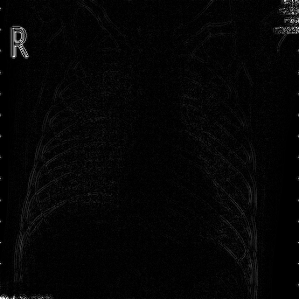

Filtro Sobel


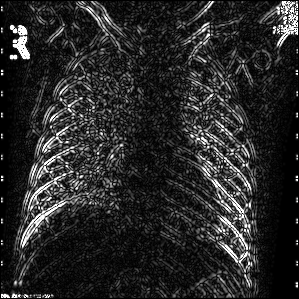

In [88]:
# 4. FILTROS PASA-BAJO Y PASA-ALTO
img_media = cv2.blur(img, (5, 5))
img_gauss = cv2.GaussianBlur(img, (5, 5), 0)
img_laplaciano = cv2.Laplacian(img, cv2.CV_64F)
img_sobel = cv2.Sobel(img, cv2.CV_64F, 1, 1, ksize=5)
print("Filtro media")
cv2_imshow(img_media)
print("Filtro Gaussiano")
cv2_imshow(img_gauss)
print("Filtro Laplaciano")
cv2_imshow(cv2.convertScaleAbs(img_laplaciano))
print("Filtro Sobel")
cv2_imshow(cv2.convertScaleAbs(img_sobel))

**Segmentación por umbral fijo y adaptativo**

Asimismo, se implementa la segmentación por umbral, una técnica para separar regiones de interés basándose en la intensidad de los píxeles. En este caso, se empieza con un umbral fijo (127) y se incluye un control deslizante interactivo que permite al usuario ajustar el valor del umbral en tiempo real y observar cómo cambia la segmentación de la imagen.



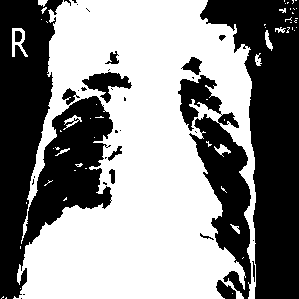

In [89]:
# 5. SEGMENTACIÓN POR UMBRAL ADAPTATIVO

#def update_threshold(val):
   # _, thresh = cv2.threshold(img, val, 255, cv2.THRESH_BINARY)
    #cv2_imshow(thresh)


#slider = widgets.IntSlider(value=127, min=0, max=255, description='Umbral:')
#widgets.interact(update_threshold, val=slider)

# 5. SEGMENTACIÓN POR UMBRAL FIJO PARA PODER SUBIRLO A GITHUB (EN COLAB SOLO ELIMINAR LOS COMENTARIOS DEL CÓDIGO DE ARRIBA)

# Valor fijo del umbral
umbral = 127

# Aplicar umbral binario
_, thresh = cv2.threshold(img, umbral, 255, cv2.THRESH_BINARY)

# Mostrar imagen umbralizada
cv2_imshow(thresh)



**Transformada Fourier**

Por último, se aplica la transformada de Fourier para convertir la imagen al dominio de la frecuencia. Se visualiza el espectro de magnitudes, que muestra la distribución de frecuencias presentes en la imagen. Posteriormente, se aplica un filtro de paso bajo en el dominio de la frecuencia para eliminar componentes de alta frecuencia (como el ruido o detalles finos). Finalmente, se transforma la imagen filtrada de regreso al dominio espacial para observar los efectos de este procesamiento.



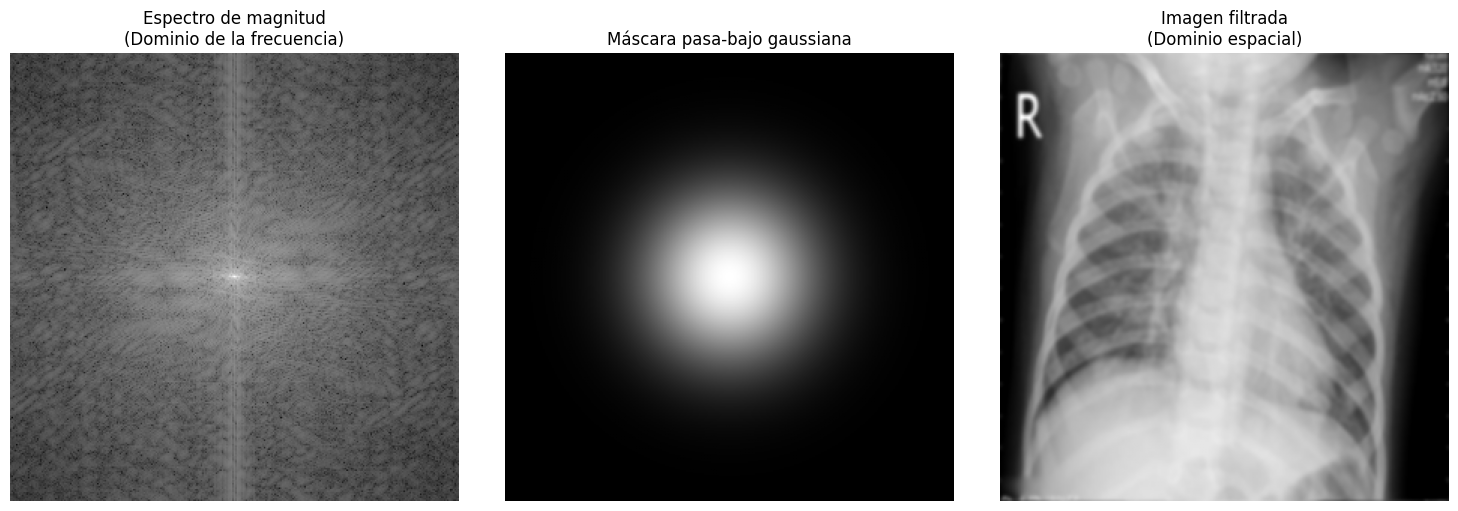

In [90]:
# 6. TRANSFORMADA DE FOURIER
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude = cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])
magnitude_log = np.log(magnitude + 1)

# 7. CREAR MÁSCARA PASA-BAJO GAUSSIANA
rows, cols = img.shape
cx, cy = cols // 2, rows // 2
x = np.linspace(-cx, cx, cols)
y = np.linspace(-cy, cy, rows)
X, Y = np.meshgrid(x, y)
sigma = 40  # Ajusta para más o menos suavizado
gauss_mask = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
gauss_mask = gauss_mask.astype(np.float32)

# Expandir a dos canales para multiplicar con dft_shift
gauss_mask_2ch = np.repeat(gauss_mask[:, :, np.newaxis], 2, axis=2)

# 8. APLICAR FILTRO EN FRECUENCIA
fshift = dft_shift * gauss_mask_2ch
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

# 9. NORMALIZAR RESULTADO
img_back_norm = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)

# 10. MOSTRAR RESULTADOS CON MATPLOTLIB
plt.figure(figsize=(15, 5))

# Espectro de magnitud
plt.subplot(1, 3, 1)
plt.imshow(magnitude_log, cmap='gray')
plt.title("Espectro de magnitud\n(Dominio de la frecuencia)")
plt.axis('off')

# Máscara pasa-bajo
plt.subplot(1, 3, 2)
plt.imshow(gauss_mask, cmap='gray')
plt.title("Máscara pasa-bajo gaussiana")
plt.axis('off')

# Imagen después del filtrado
plt.subplot(1, 3, 3)
plt.imshow(img_back_norm, cmap='gray')
plt.title("Imagen filtrada\n(Dominio espacial)")
plt.axis('off')

plt.tight_layout()
plt.show()